### Stops extraction and classification

This section is in charge of extracting the stops for each travel and classifying them using K-means clustering. The main idea is to find consecutive GPS points whose duration is longer than a threshold, in this case, 3 minutes.

Following the proposed method in the case study “Identifying business activity-travel patterns based on GPS data” [3] it's necessary to build the locations given the following structure:
L(z, ts, te, day, dis, int)

| Variable | description |
| --- | --- |
| Z | Represents the GPS zone location |
| ts | Start time |
| te | End time |
| dis | distance from previous location |
| int | time to travel from previous location |

The duration of a stop is given by `(te - ts)`

The zone locations are build using K-mean clustering.


In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn shapely geopandas

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time as time
import seaborn as sns
from sklearn.cluster import KMeans
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### S

In [120]:
# Helper functions
#Given a stop-location-path
# zm, tsm, tem, day, dism, intm
# z(xy): plane
# ts: time StopIteration
# tem: time end
#day
#dism: distance
#int: ? id of location


def loadTravel(filename):
    travel = pd.read_csv(filename, sep=',', skiprows=0)
    return travel

speedThreshold = 0
durationThreshold = 5

def buildLocation(travel):
    d = travel.groupby()



def extractStop(travel, locations):
    t = travel[['id','latitude', 'longitude']]
    # t = t.drop_duplicates(subset=('longitude', 'latitude'), keep="first")
    # print(t)
    locations.extend(t.values.tolist())
    print('Locations size: ',len(locations))


In [121]:

# assign directory
directory = '../datasets/travels'
 
# iterate over files in
# that directory
coordinates = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file

    if os.path.isfile(f):
      #  travel = loadTravel(f)
       # extractStop(travel, locations)
        try:
            travel = loadTravel(f)
            extractStop(travel, coordinates)
        except Exception:
            print("Some other exception", f)


Locations size:  619
Locations size:  825
Locations size:  1249
Locations size:  2204
Locations size:  2413
Locations size:  2702
Locations size:  3386
Locations size:  4729
Locations size:  5373
Locations size:  5389
Locations size:  8389
Locations size:  11389
Locations size:  13191
Locations size:  16191
Some other exception ../datasets/travels/201060-travel-2022-10-01.csv
Locations size:  16767
Locations size:  17345
Some other exception ../datasets/travels/261065-travel-2022-10-01.csv
Locations size:  17799
Locations size:  18861
Locations size:  19224
Locations size:  19588
Locations size:  19591
Locations size:  19965
Locations size:  20044
Some other exception ../datasets/travels/261108-travel-2022-10-01.csv
Locations size:  20351
Some other exception ../datasets/travels/201163-travel-2022-10-01.csv
Locations size:  20647
Some other exception ../datasets/travels/200000-travel-2022-10-01.csv
Locations size:  20672
Locations size:  20869
Locations size:  23869
Locations size:  24

In [122]:
gpsZones = pd.DataFrame(coordinates, columns=['id', 'latitude', 'longitude'])
gpsZones.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
print('Gps zones size:', len(gpsZones))

gpsZones.head(10)

Gps zones size: 1739146


,id,latitude,longitude
0,5580.0,4.622721,-74.090770
1,30839.0,4.622721,-74.090770
2,52356.0,4.622721,-74.090770
3,72708.0,4.622721,-74.090770
4,90602.0,4.622718,-74.090765
5,112083.0,4.622718,-74.090765
6,132301.0,4.622718,-74.090765
7,144882.0,4.622718,-74.090765
8,172511.0,4.622728,-74.090721
9,193286.0,4.622728,-74.090721


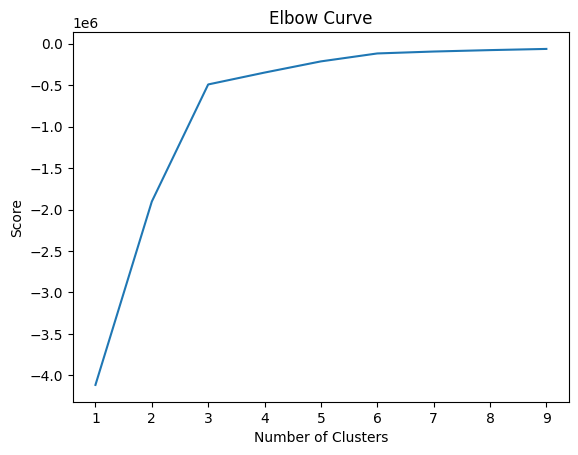

In [123]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = gpsZones[['latitude']]
X_axis = gpsZones[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [124]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(gpsZones[gpsZones.columns[1:3]]) # Compute k-means clustering.
gpsZones['cluster'] = kmeans.fit_predict(gpsZones[gpsZones.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(gpsZones[gpsZones.columns[1:3]]) # Labels of each point
gpsZones.head(10)


,id,latitude,longitude,cluster
0,5580.0,4.622721,-74.090770,4
1,30839.0,4.622721,-74.090770,4
2,52356.0,4.622721,-74.090770,4
3,72708.0,4.622721,-74.090770,4
4,90602.0,4.622718,-74.090765,4
5,112083.0,4.622718,-74.090765,4
6,132301.0,4.622718,-74.090765,4
7,144882.0,4.622718,-74.090765,4
8,172511.0,4.622728,-74.090721,4
9,193286.0,4.622728,-74.090721,4


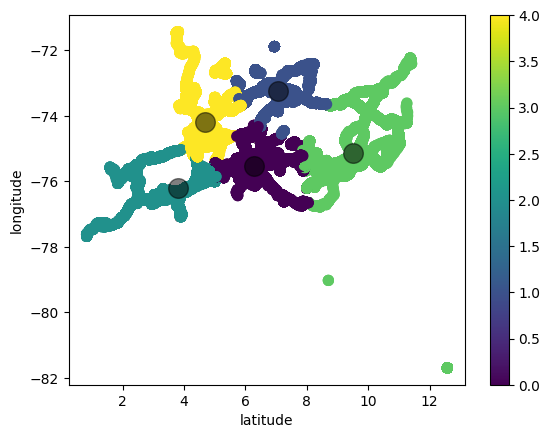

In [125]:
gpsZones.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('K-means clustering result')

In [135]:
print(gpsZones.head(5))

geo = GeoDataFrame(gpsZones, geometry = gpd.points_from_xy(gpsZones.longitude, gpsZones.latitude))

        id  latitude  longitude  cluster                   geometry
0   5580.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
1  30839.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
2  52356.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
3  72708.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
4  90602.0  4.622718 -74.090765        4  POINT (-74.09077 4.62272)


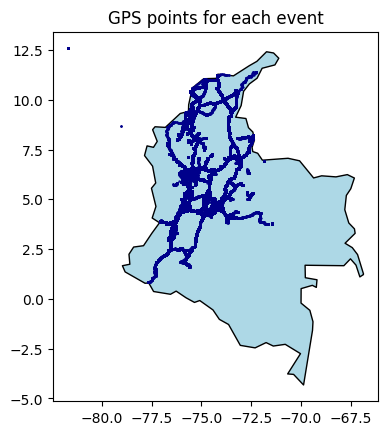

In [138]:
#Plot each gps point
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name == "Colombia"].plot(color= 'lightblue', edgecolor='black')
plt.title('GPS points for each event in Colombia')

geo.plot(ax=world, color = 'darkblue', markersize=0.4);

